# Import dataset from Kaggle

Configure Kaggle credential before download the dataset

In [1]:
import kagglehub
import os
import yaml
import matplotlib.pyplot as plt
import cv2

import shutil
import torch
import torch.nn as nn
from ultralytics import YOLO

# Download latest version
DATASET = kagglehub.dataset_download("budikawira/container-cnr")

print("Path to dataset files:", DATASET)

Path to dataset files: C:\Users\budik\.cache\kagglehub\datasets\budikawira\container-cnr\versions\1


# Dataset EDA

Check classes instance in the dataset

In [2]:
from pathlib import Path
import pandas as pd
from collections import Counter

class_names = ["Serial Number", "Owner Prefix", "ISO6346", "V Serial Number", "V Owner Prefix", "V ISO6346"]
labels_path = Path(DATASET + '/train/labels')
class_counter = Counter()

for txt_file in labels_path.glob('*.txt'):
    try:
        content = txt_file.read_text().splitlines()
        for line in content:
            class_id = int(line.split()[0])
            class_counter[class_id] += 1
    except Exception as e:
        print(f"Error reading {txt_file.name}: {e}")

# Create DataFrame
df = pd.DataFrame([(cls, count) for cls, count in class_counter.items()],
                 columns=['ClassId', 'Instances']).sort_values('ClassId')
df['Class'] = df['ClassId'].apply(lambda x: class_names[x])
df.sort_index()
print(df)

   ClassId  Instances            Class
0        0        302    Serial Number
2        1        280     Owner Prefix
1        2        284          ISO6346
4        3         65  V Serial Number
5        4         60   V Owner Prefix
3        5         53        V ISO6346


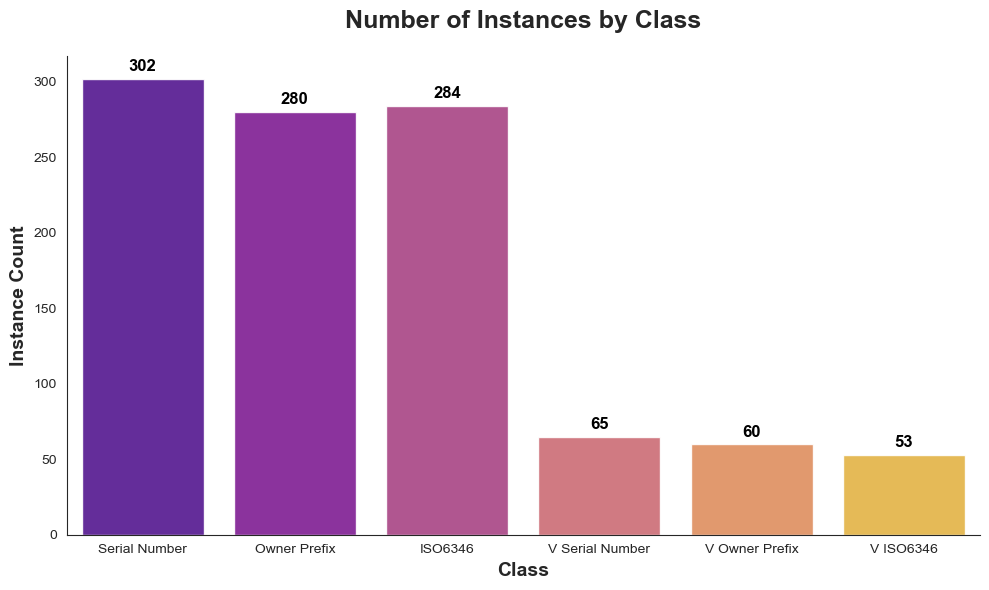

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")
plt.figure(figsize=(10, 6))

# ✅ Use `hue` to assign palette per class
ax = sns.barplot(
    data=df,
    x='Class',
    y='Instances',
    hue='Class',           # ← Assign hue to enable palette
    palette='plasma',
    legend=False,          # ← Hide legend (we don't need it for simple bar plots)
    alpha=0.9
)

# Customize labels and title
plt.title('Number of Instances by Class', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Class', fontsize=14, fontweight='semibold')
plt.ylabel('Instance Count', fontsize=14, fontweight='semibold')

# Add value labels on bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.,
        height + max(df['Instances']) * 0.01,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Remove borders
sns.despine()

# Layout
plt.tight_layout()
plt.show()

# Model Training

In [4]:
DATASET_TRAIN = DATASET + "/train.csv"
DATASET_TEST = DATASET + "/test.csv"

In [5]:
def print_trainable_layers(model):
    print("Trainable layers:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f" - {name}")

def print_frozen_layers(model):
    print("Frozen layers:")
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f" - {name}")

In [6]:
PROJECT = "runs/detect1"
NAME = "cnr" # store Container Number Record model state here

shutil.rmtree(os.path.join(PROJECT, NAME), ignore_errors=True)

In [7]:
model = YOLO("yolo11n.pt")  # Load pretrained model

print(model.model)

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
   

In [8]:
# Ensure that all layers are trainable
for name, param in model.model.named_parameters():
    param.requires_grad = True

print_frozen_layers(model.model)
print_trainable_layers(model.model)

Frozen layers:
Trainable layers:
 - model.0.conv.weight
 - model.0.bn.weight
 - model.0.bn.bias
 - model.1.conv.weight
 - model.1.bn.weight
 - model.1.bn.bias
 - model.2.cv1.conv.weight
 - model.2.cv1.bn.weight
 - model.2.cv1.bn.bias
 - model.2.cv2.conv.weight
 - model.2.cv2.bn.weight
 - model.2.cv2.bn.bias
 - model.2.m.0.cv1.conv.weight
 - model.2.m.0.cv1.bn.weight
 - model.2.m.0.cv1.bn.bias
 - model.2.m.0.cv2.conv.weight
 - model.2.m.0.cv2.bn.weight
 - model.2.m.0.cv2.bn.bias
 - model.3.conv.weight
 - model.3.bn.weight
 - model.3.bn.bias
 - model.4.cv1.conv.weight
 - model.4.cv1.bn.weight
 - model.4.cv1.bn.bias
 - model.4.cv2.conv.weight
 - model.4.cv2.bn.weight
 - model.4.cv2.bn.bias
 - model.4.m.0.cv1.conv.weight
 - model.4.m.0.cv1.bn.weight
 - model.4.m.0.cv1.bn.bias
 - model.4.m.0.cv2.conv.weight
 - model.4.m.0.cv2.bn.weight
 - model.4.m.0.cv2.bn.bias
 - model.5.conv.weight
 - model.5.bn.weight
 - model.5.bn.bias
 - model.6.cv1.conv.weight
 - model.6.cv1.bn.weight
 - model.6.cv1.

In [9]:
# Train with custom learning rate and optimizer
results = model.train(
    data=os.path.join(DATASET, "data.yaml"),
    epochs=80,
    batch=16,
    imgsz=640,
    optimizer="AdamW",
    lr0=0.001,              # Standard starting LR
    lrf=0.01,               # Final LR after decay
    momentum=0.9,
    weight_decay=0.0005,    
    warmup_epochs=3,        # Stabilize early training
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    cos_lr=True,            # Smooth cosine decay helps convergence
    device=0,
    workers=16,
    project=PROJECT,
    name=NAME,
    # --- Augmentation Settings ---
    
    # --- Valid Augmentation Parameters ---
    fliplr=0.0,          # Disable horizontal flip (left-right)
    flipud=0.0,          # Disable vertical flip (up-down)
    degrees=30.0,        # Random rotation (±30°)
    translate=0.1,       # Image translation (10% of image size)
    scale=0.5,           # Image zoom (50%-150%)
    
    # --- Blur Alternatives ---
    hsv_h=0.015,         # Hue variation (1.5%)
    hsv_s=0.7,           # Saturation variation (70%)
    hsv_v=0.4,           # Value (brightness) variation (40%)
    mosaic=1.0,          # Enable mosaic augmentation (disable if blur needed)
    copy_paste=0.0       # Disable copy-paste augmentation
)


New https://pypi.org/project/ultralytics/8.3.197 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.152  Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\budik\.cache\kagglehub\datasets\budikawira\container-cnr\versions\1\data.yaml, degrees=30.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.9, mosaic=1.0

train: Scanning Z:\BEKA\2025\AI\Project\Container\Dataset\cnr\train\labels.cache... 315 images, 0 backgrounds, 0 corrup


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 330.0204.1 MB/s, size: 38.6 KB)


val: Scanning Z:\BEKA\2025\AI\Project\Container\Dataset\cnr\val\labels.cache... 135 images, 0 backgrounds, 0 corrupt: 1


Plotting labels to runs\detect1\cnr\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 16 dataloader workers
Logging results to runs\detect1\cnr
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      2.32G      2.102       4.45       1.71         56        640: 100%|██████████| 20/20 [00:08<00:00,  2.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466   0.000379       0.12     0.0038    0.00101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      2.73G      1.543      3.078      1.283         42        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.168      0.153      0.147     0.0367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      2.73G      1.482      2.277      1.236         64        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466     0.0693      0.133       0.11     0.0556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      2.73G      1.445      1.726      1.219         72        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466     0.0921      0.175      0.115     0.0676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      2.73G      1.329      1.495      1.172         44        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.189      0.663      0.415      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      2.73G      1.351       1.47      1.144         48        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.758      0.371      0.587      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      2.73G      1.329      1.356      1.152         56        640: 100%|██████████| 20/20 [00:02<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.627      0.501      0.631      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      2.73G      1.304      1.269      1.134         42        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.625      0.564      0.604       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      2.73G      1.294      1.215      1.126         72        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.683      0.643      0.682      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      2.73G      1.262      1.237      1.119         36        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.647      0.527      0.563        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      2.73G      1.211      1.134      1.108         39        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.689      0.687      0.701      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      2.73G      1.196      1.121        1.1         73        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<0

                   all        135        466      0.717      0.577      0.607      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      2.73G      1.205      1.101      1.083         56        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.743      0.709      0.755      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      2.73G      1.197      1.082      1.084         68        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.769      0.732       0.79      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      2.73G      1.137     0.9826      1.069         46        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.757      0.704      0.743       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      2.73G      1.215      1.013      1.093         38        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.742      0.679      0.724       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      2.73G      1.148     0.9655      1.068         64        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.772      0.734       0.76      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      2.73G      1.114      0.929      1.049         67        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.776      0.749       0.79      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      2.73G      1.162     0.9539      1.067         44        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.814      0.763      0.811      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      2.73G      1.165     0.9371      1.064         38        640: 100%|██████████| 20/20 [00:03<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466       0.78      0.725      0.814      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      2.73G      1.157      0.945      1.079         39        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.841      0.695      0.838      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      2.73G       1.11     0.9223      1.062         41        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.771      0.755      0.804      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      2.73G      1.121     0.8739      1.054         54        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.821      0.761      0.804      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      2.73G      1.096     0.8576      1.043         41        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.829      0.769      0.825      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      2.73G      1.133     0.8766      1.058         59        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.829      0.781       0.86      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      2.73G      1.153     0.8778      1.084         71        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.793      0.783      0.813      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      2.73G      1.189     0.8807      1.074         44        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.808      0.801      0.839       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      2.73G      1.162     0.8511      1.064         62        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.861      0.799      0.874      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      2.73G      1.099     0.8319      1.039         49        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.897      0.758      0.857      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      2.73G      1.073     0.7926      1.039         70        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466       0.85       0.82       0.86      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      2.73G      1.081     0.8201      1.034         57        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.831      0.813      0.868      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      2.73G      1.066     0.7848      1.018         58        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.758       0.81      0.823      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      2.73G      1.065     0.8004      1.024         79        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<0

                   all        135        466       0.84      0.772       0.83      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      2.73G      1.062     0.7816      1.049         60        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.851        0.8      0.871      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      2.73G      1.053     0.7417      1.027         50        640: 100%|██████████| 20/20 [00:03<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<0

                   all        135        466      0.868      0.807      0.877       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      2.73G      1.024     0.7331      1.015         73        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466       0.86       0.82      0.877      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      2.73G       1.04     0.7375      1.017         52        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.867      0.846        0.9      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      2.73G      1.022     0.7427     0.9919         29        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.827      0.833      0.855      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      2.73G      1.087     0.7496      1.025         29        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.837      0.791       0.84      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      2.73G      1.056     0.7341      1.018         55        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.885      0.837      0.877      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      2.73G     0.9844     0.6949     0.9817         67        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.923      0.817      0.889      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      2.73G      1.011     0.6997      1.003         67        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.932      0.827      0.915      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      2.73G     0.9916      0.682     0.9803         52        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.875       0.86      0.902      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      2.73G     0.9565     0.6541     0.9782         52        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466       0.85      0.849      0.902      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      2.73G     0.9876     0.6793          1         41        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.901       0.85      0.913      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      2.73G     0.9799     0.6715     0.9895         43        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.854      0.905      0.919      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      2.73G     0.9789     0.6705      1.005         50        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.876       0.91      0.927      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      2.73G     0.9688     0.6718      0.992         39        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.897      0.881      0.924      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      2.73G     0.9527     0.6487     0.9861         68        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.886       0.87      0.925      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      2.73G     0.9737      0.675     0.9966         69        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.918      0.857       0.93      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      2.73G     0.9632     0.6464     0.9792         47        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.889      0.882      0.931      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      2.73G      0.995     0.6693     0.9922         53        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.905      0.865      0.914      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      2.73G     0.9866     0.6674     0.9912         55        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.914      0.877      0.928      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      2.73G     0.9064     0.6082     0.9545         65        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466       0.89      0.914      0.939      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      2.73G     0.9118     0.6086     0.9696         44        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.922      0.889      0.936      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      2.73G     0.9435     0.6197     0.9757         50        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<0

                   all        135        466      0.916      0.885      0.931      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      2.73G     0.9243     0.6142     0.9659         54        640: 100%|██████████| 20/20 [00:05<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.926      0.885      0.938       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      2.73G     0.9201     0.6214       0.98         54        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.904      0.894      0.935       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      2.73G     0.9221     0.6165     0.9668         49        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<0

                   all        135        466       0.91       0.89      0.934      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      2.73G     0.8984     0.5872     0.9704         80        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.922      0.889      0.933      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      2.73G     0.8949     0.5878     0.9503         58        640: 100%|██████████| 20/20 [00:03<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.926      0.905      0.937      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      2.73G     0.8965     0.6031     0.9525         45        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.916      0.902      0.927       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      2.73G      0.893     0.5925     0.9586         48        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.923      0.891      0.933      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      2.73G      0.876     0.5754     0.9521         38        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.918      0.909       0.93       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      2.73G     0.9215     0.5898     0.9512         54        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.918      0.914      0.936      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      2.73G     0.8754      0.578     0.9584         50        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.908      0.914      0.933      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      2.73G     0.8598     0.5647     0.9558         48        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<0

                   all        135        466       0.89      0.918      0.933      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      2.73G     0.8786     0.5759     0.9511         49        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.932      0.881      0.932      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      2.73G     0.8656     0.5885     0.9456         49        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.928      0.891      0.931      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      2.73G     0.8494     0.5639     0.9461         46        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.938      0.888      0.937      0.596


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      2.73G      0.833     0.5313     0.9763         36        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.932      0.904       0.93      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      2.73G     0.8325     0.5396     0.9792         35        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.928      0.902      0.927      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      2.73G     0.8269     0.5341     0.9696         33        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.925      0.907       0.93       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      2.73G     0.8221     0.5179     0.9799         37        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.916      0.907      0.928      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      2.73G     0.8286     0.5201     0.9559         33        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.924       0.91      0.929      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      2.73G     0.8176      0.529     0.9574         36        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.922       0.91      0.928      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      2.73G     0.8201     0.5167      0.969         36        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.928      0.907      0.928      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      2.73G     0.8184     0.5166     0.9694         32        640: 100%|██████████| 20/20 [00:04<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.927      0.907      0.929      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      2.73G     0.8188     0.5219     0.9475         27        640: 100%|██████████| 20/20 [00:03<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.927      0.906      0.929      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      2.73G     0.8185     0.5196     0.9517         31        640: 100%|██████████| 20/20 [00:03<00:00,  5.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0

                   all        135        466      0.929      0.904       0.93      0.593



80 epochs completed in 0.143 hours.
Optimizer stripped from runs\detect1\cnr\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect1\cnr\weights\best.pt, 5.5MB

Validating runs\detect1\cnr\weights\best.pt...
Ultralytics 8.3.152  Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<0


                   all        135        466      0.891      0.914      0.939      0.606
         Serial Number        114        128      0.868      0.906      0.942      0.642
          Owner Prefix        110        122      0.973      0.889      0.935      0.665
               ISO6346        113        122       0.95      0.927      0.961      0.681
       V Serial Number         33         34      0.773      0.971       0.89      0.483
        V Owner Prefix         34         35      0.865      0.916      0.944      0.589
             V ISO6346         24         25      0.916      0.874      0.961      0.575
Speed: 0.8ms preprocess, 2.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect1\cnr


In [10]:
# copy the best model to the Deployment folder
best = './' + PROJECT + '/' + NAME + "/weights/best.pt"
deploy = "./Deploy/assets/cnr.pt"
os.makedirs(os.path.dirname(deploy), exist_ok=True)
shutil.copy(best, deploy)

'./Deploy/assets/cnr.pt'

## End of Script